In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
from sklearn.model_selection import train_test_split
import os

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

print(os.listdir("../input"))
print(os.listdir("../working"))


# Any results you write to the current directory are saved as output.

['testing-data', 'lucifer', 'fyprmfrd', 'facenet', 'pin-face-daraset', 'test-data']
[]


# maskTheFace Approach

In [ ]:
!git clone https://github.com/aqeelanwar/MaskTheFace.git
%cd MaskTheFace

!pip install -r requirements.txt



In [4]:
import os
import shutil
import random
from PIL import Image

# === Paths ===
SOURCE_DIR = '/kaggle/input/pin-face-daraset/105_classes_pins_dataset'
NORMALIZED_DIR = '/kaggle/working/normalized_dataset'
CLEANED_DIR = '/kaggle/working/normalized_dataset_cleaned'
TARGET_IMAGES_PER_PERSON = 150

def is_valid_image(img_path):
    try:
        img = Image.open(img_path)
        img.verify()
        return True
    except:
        return False

# === Step 1: Normalize dataset ===
os.makedirs(NORMALIZED_DIR, exist_ok=True)
print("🔄 Normalizing dataset to 150 images/person...")

for person in os.listdir(SOURCE_DIR):
    person_path = os.path.join(SOURCE_DIR, person)
    if not os.path.isdir(person_path): continue

    images = [img for img in os.listdir(person_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not images: continue

    os.makedirs(os.path.join(NORMALIZED_DIR, person), exist_ok=True)
    selected = random.sample(images, TARGET_IMAGES_PER_PERSON) if len(images) >= TARGET_IMAGES_PER_PERSON else images.copy()

    while len(selected) < TARGET_IMAGES_PER_PERSON:
        selected.append(random.choice(images))

    for i, img_name in enumerate(selected):
        shutil.copy(
            os.path.join(person_path, img_name),
            os.path.join(NORMALIZED_DIR, person, f"{person}_{i+1}.jpg")
        )
print("✅ Normalization complete.")

# === Step 2: Clean corrupted images ===
os.makedirs(CLEANED_DIR, exist_ok=True)
print("🧹 Cleaning corrupted images...")

for person in os.listdir(NORMALIZED_DIR):
    src_folder = os.path.join(NORMALIZED_DIR, person)
    dst_folder = os.path.join(CLEANED_DIR, person)
    os.makedirs(dst_folder, exist_ok=True)

    for img_file in os.listdir(src_folder):
        src_img = os.path.join(src_folder, img_file)
        dst_img = os.path.join(dst_folder, img_file)
        if is_valid_image(src_img):
            shutil.copy(src_img, dst_img)
print("✅ Cleaning complete.")

# === Step 3: Patch mask_the_face.py to ensure .jpg extension ===
def patch_mask_script():
    with open('mask_the_face.py', 'r') as f:
        lines = f.readlines()

    patched = []
    for i, line in enumerate(lines):
        if 'cv2.imwrite(w_path, img)' in line:
            indent = line[:len(line) - len(line.lstrip())]
            patched.append(f"{indent}if not w_path.lower().endswith(('.jpg', '.jpeg', '.png')):\n")
            patched.append(f"{indent}    w_path += '.jpg'\n")
        patched.append(line)

    with open('mask_the_face.py', 'w') as f:
        f.writelines(patched)

    print("🛠 Patched mask_the_face.py successfully.")

patch_mask_script()  # Apply patch

# === Step 4: Run MaskTheFace ===
print("😷 Applying MaskTheFace...")
!python mask_the_face.py \
    --path /kaggle/working/normalized_dataset_cleaned \
    --mask_type surgical \
    --verbose > /kaggle/working/mask_output.log

print("✅ Masking complete. Output saved to `/kaggle/working/normalized_dataset_cleaned_masked`")


🔄 Normalizing dataset to 150 images/person...
✅ Normalization complete.
🧹 Cleaning corrupted images...
✅ Cleaning complete.
🛠 Patched mask_the_face.py successfully.
😷 Applying MaskTheFace...
0it [00:00, ?it/s]
100%|█████████████████████████████████████████| 105/105 [12:54<00:00,  7.37s/it]
✅ Masking complete. Output saved to `/kaggle/working/normalized_dataset_cleaned_masked`


# training only on unmasked data


In [5]:
#  Install & Import Required Libraries
!pip install facenet-pytorch -q

import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1, MTCNN


In [6]:
#  Define Paths to Datasets
unmasked_dir = "/kaggle/working/normalized_dataset_cleaned/"
masked_dir = "/kaggle/working/normalized_dataset_cleaned_masked/"


In [7]:
#  Initialize Face Detector and FaceNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mtcnn = MTCNN(image_size=160, margin=20, keep_all=False, post_process=True, device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)


In [8]:
#  Function to Load Images, Detect Face, and Get Embeddings
def get_embeddings(dataset_path):
    embeddings = []
    labels = []
    label_map = {}

    for i, person in enumerate(sorted(os.listdir(dataset_path))):
        person_dir = os.path.join(dataset_path, person)
        if not os.path.isdir(person_dir): continue

        label_map[i] = person
        for img_name in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                face = mtcnn(img)
                if face is not None:
                    face = face.unsqueeze(0).to(device)
                    emb = facenet(face).detach().cpu().numpy()[0]
                    embeddings.append(emb)
                    labels.append(i)
            except:
                pass

    return np.array(embeddings), np.array(labels), label_map


In [9]:
#  Load and Embed Unmasked Images (Training Set)
print("Extracting embeddings from unmasked dataset...")
train_embeddings, train_labels, label_map = get_embeddings(unmasked_dir)


Extracting embeddings from unmasked dataset...


In [10]:
#  Load and Embed Masked Images (Testing Set)
print("Extracting embeddings from masked dataset...")
test_embeddings, test_labels, _ = get_embeddings(masked_dir)


Extracting embeddings from masked dataset...


In [11]:
#  Train Classifier (SVM)
clf = SVC(kernel='linear', probability=True)
clf.fit(train_embeddings, train_labels)


SVC(kernel='linear', probability=True)

In [ ]:
#  Evaluate on Masked Test Set
predictions = clf.predict(test_embeddings)
acc = accuracy_score(test_labels, predictions)
print(f"Accuracy on masked dataset: {acc:.4f}")

print("\nClassification Report:\n")
print(classification_report(test_labels, predictions, target_names=[label_map[i] for i in sorted(label_map.keys())]))


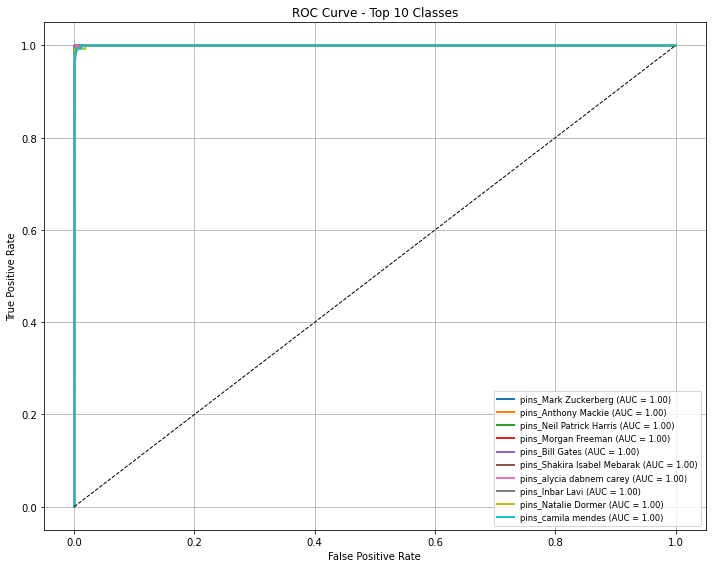

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming you have:
# y_score: predicted probabilities (n_samples, n_classes)
# test_labels: true labels
# label_map: class ID → name (dict)

# Binarize test labels
classes = sorted(label_map.keys())
y_test_bin = label_binarize(test_labels, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}

# Calculate AUC for each class
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Sort classes by AUC score
sorted_classes = sorted(roc_auc, key=roc_auc.get, reverse=True)
top_n = 10  # Show only top 10 for clarity

plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, top_n))

for idx, i in enumerate(sorted_classes[:top_n]):
    plt.plot(fpr[i], tpr[i], color=colors[idx], lw=2,
             label=f"{label_map[classes[i]]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Top {top_n} Classes')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()



In [16]:
plt.figure(figsize=(20, 15))
for i in sorted_classes:
    plt.plot(fpr[i], tpr[i], lw=1, label=f"{label_map[classes[i]]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - All Classes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)
plt.tight_layout()
plt.savefig("all_class_roc_curve.png", dpi=300, bbox_inches='tight')
plt.close()


In [17]:
import shutil
shutil.move("all_class_roc_curve.png", "/kaggle/working/all_class_roc_curve.png")


'/kaggle/working/all_class_roc_curve.png'

In [18]:
!ls /kaggle/working


MaskTheFace		 mask_output.log     normalized_dataset_cleaned
all_class_roc_curve.png  normalized_dataset  normalized_dataset_cleaned_masked


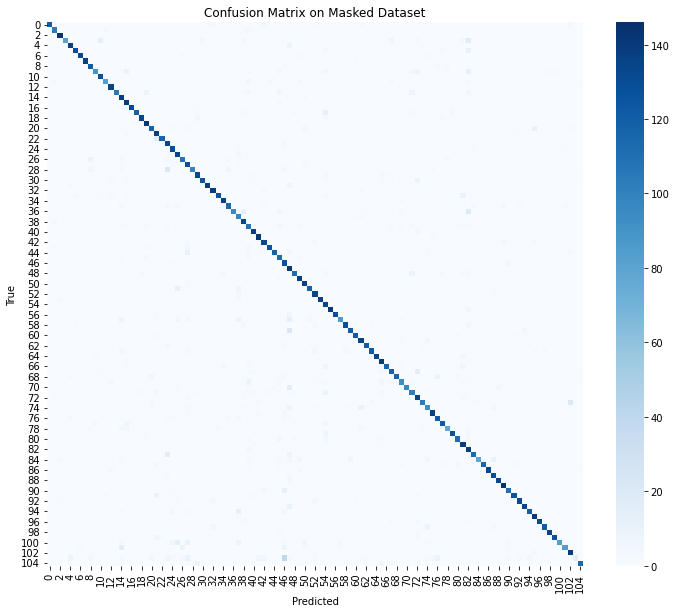

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues')
plt.title("Confusion Matrix on Masked Dataset")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
def recognize_masked_face(image_path, facenet, clf, mtcnn, label_map):
    img = Image.open(image_path).convert("RGB")
    face = mtcnn(img)
    if face is None:
        return "No face detected"
    face = face.unsqueeze(0).to(device)
    emb = facenet(face).cpu().detach().numpy()
    pred = clf.predict(emb)[0]
    return label_map[pred]


In [ ]:
result = recognize_masked_face("/kaggle/input/test-data/test img.jpeg", facenet, clf, mtcnn, label_map)
print("Predicted identity:", result)


# training on both data

In [19]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
!pip install facenet_pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

mtcnn = MTCNN(image_size=160, margin=20, keep_all=False, device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)


In [21]:
unmasked_dir = "/kaggle/working/normalized_dataset_cleaned/"
masked_dir = "/kaggle/working/normalized_dataset_cleaned_masked/"

In [22]:
X = []
y = []

def process_directory(dataset_path):
    for person in tqdm(os.listdir(dataset_path)):
        person_dir = os.path.join(dataset_path, person)
        if not os.path.isdir(person_dir):
            continue
        for img_name in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                face = mtcnn(img)
                if face is not None:
                    face = face.unsqueeze(0).to(device)
                    with torch.no_grad():
                        emb = facenet(face).cpu().numpy()
                    X.append(emb.squeeze())
                    y.append(person)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")

# Process both folders
process_directory(unmasked_dir)
process_directory(masked_dir)

X = np.array(X)
y = np.array(y)

print(f"Total samples: {len(X)}")


100%|██████████| 105/105 [27:44<00:00, 15.85s/it]

Total samples: 30453


In [26]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
label_map = dict(zip(le.transform(le.classes_), le.classes_))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 24362, Test size: 6091


In [27]:
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)


SVC(kernel='linear', probability=True)

In [28]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy on combined dataset: {acc:.4f}")


Accuracy on combined dataset: 0.9719


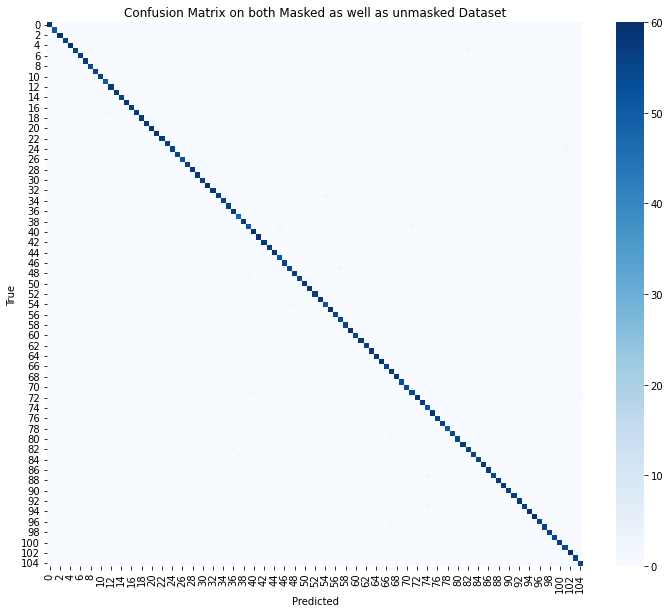

In [31]:
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# 1. CONFUSION MATRIX
# -------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues')
plt.title("Confusion Matrix on both Masked as well as unmasked Dataset")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

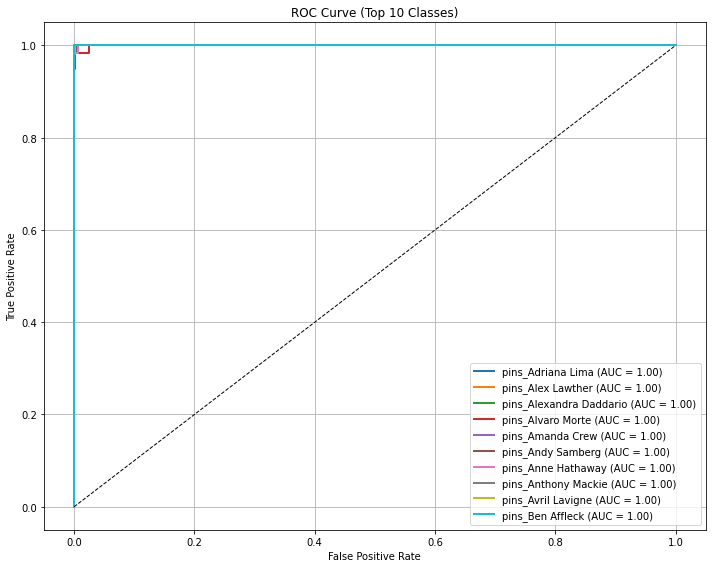

Micro-Averaged AUC: 0.9997
Macro-Averaged AUC: 0.9997


In [34]:
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))
y_score = clf.predict_proba(X_test)

# Compute ROC and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for top 5 classes (or all if less than 5)
plt.figure(figsize=(10, 8))
top_n = min(10, n_classes)
colors = plt.cm.tab10(np.linspace(0, 1, top_n))

for i, color in zip(range(top_n), colors):
    plt.plot(fpr[i], tpr[i], lw=2, color=color,
             label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Top 10 Classes)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# 3. MICRO and MACRO AVERAGED AUC
# -------------------------
micro_auc = roc_auc_score(y_test_bin, y_score, average='micro')
macro_auc = roc_auc_score(y_test_bin, y_score, average='macro')

print(f"Micro-Averaged AUC: {micro_auc:.4f}")
print(f"Macro-Averaged AUC: {macro_auc:.4f}")

In [ ]:
def predict_identity(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        face = mtcnn(img)
        if face is not None:
            face = face.unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = facenet(face).cpu().numpy()
            pred = clf.predict(embedding)
            label = le.inverse_transform(pred)[0]
            return label
        else:
            return "No face detected"
    except Exception as e:
        return f"Error: {e}"



In [ ]:
image_path = "/kaggle/input/testing-data/test2.jpeg"  # Replace with your image path
result = predict_identity(image_path)
print("Predicted Identity:", result)

# training only on masked data

In [35]:
masked_dir = '/kaggle/working/normalized_dataset_cleaned_masked/'  # your masked dataset path

X = []
y = []


In [36]:
def process_directory(dataset_path):
    for person in tqdm(os.listdir(dataset_path)):
        person_dir = os.path.join(dataset_path, person)
        if not os.path.isdir(person_dir):
            continue
        for img_name in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                face = mtcnn(img)
                if face is not None:
                    face = face.unsqueeze(0).to(device)
                    with torch.no_grad():
                        emb = facenet(face).cpu().numpy()
                    X.append(emb.squeeze())
                    y.append(person)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")


In [37]:
process_directory(masked_dir)


100%|██████████| 105/105 [29:26<00:00, 16.82s/it]


In [38]:
X = np.array(X)
y = np.array(y)

le = LabelEncoder()
y_enc = le.fit_transform(y)

clf = SVC(kernel='linear', probability=True)
clf.fit(X, y_enc)


SVC(kernel='linear', probability=True)

In [ ]:
joblib.dump(clf, 'svm_facenet_masked.pkl')
joblib.dump(le, 'label_encoder_masked.pkl')


In [39]:
y_pred = clf.predict(X)
acc = accuracy_score(y_enc, y_pred)
print(f"Accuracy on masked dataset: {acc:.4f}")
   

Accuracy on masked dataset: 0.9755


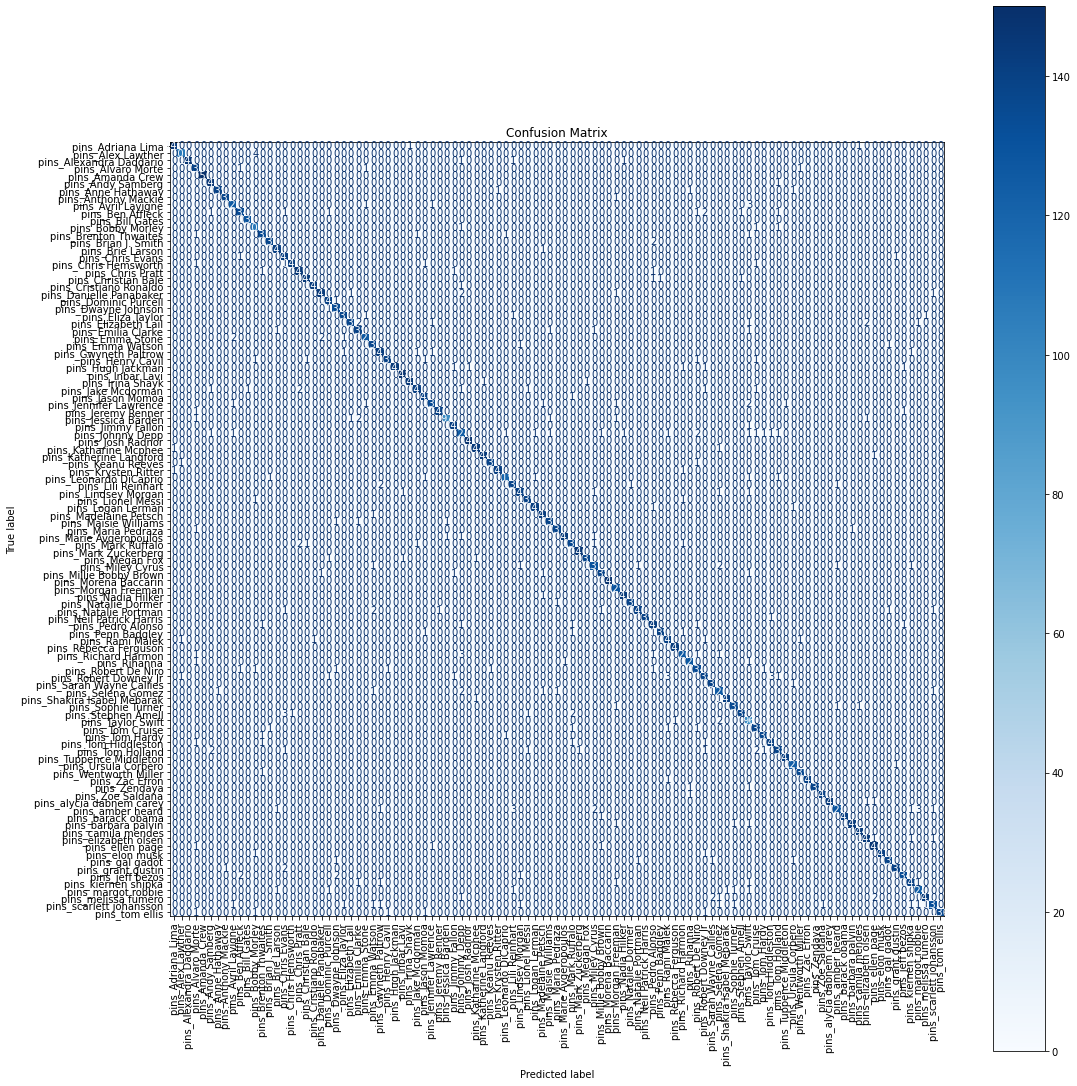

In [42]:
cm = confusion_matrix(y_enc, y_pred)

fig, ax = plt.subplots(figsize=(16, 16))  # Increase the size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=90, ax=ax)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

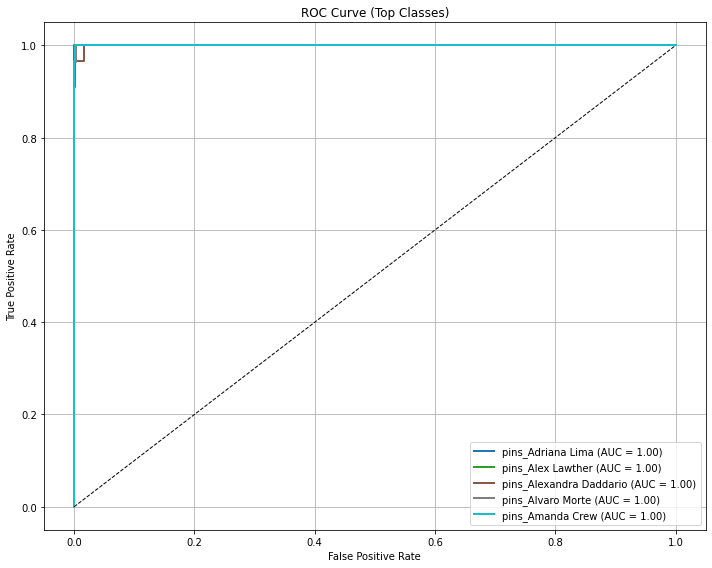

Macro AUC: 0.9987
Micro AUC: 0.9988


In [44]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
n_classes = len(le.classes_)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# Train SVC
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

# Get predicted probabilities
y_score = clf.predict_proba(X_test)

# Binarize true labels
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and AUC for top N classes
fpr, tpr, roc_auc = {}, {}, {}
top_n = min(5, n_classes)
for i in range(top_n):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, top_n))
for i, color in zip(range(top_n), colors):
    plt.plot(fpr[i], tpr[i], lw=2, color=color,
             label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Top Classes)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: macro/micro AUC
macro_auc = roc_auc_score(y_test_bin, y_score, average='macro')
micro_auc = roc_auc_score(y_test_bin, y_score, average='micro')
print(f"Macro AUC: {macro_auc:.4f}")
print(f"Micro AUC: {micro_auc:.4f}")


In [ ]:
def predict_identity(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        face = mtcnn(img)
        if face is not None:
            face = face.unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = facenet(face).cpu().numpy()
            pred = clf.predict(embedding)
            label = le.inverse_transform(pred)[0]
            return label
        else:
            return "No face detected"
    except Exception as e:
        return f"Error: {e}"


In [ ]:
image_path = '/kaggle/input/testing-data/test2.jpeg'  # Change to your image path
result = predict_identity(image_path)
print("Predicted identity:", result)
